<a href="https://colab.research.google.com/github/weibb123/ab_test_web_design/blob/main/ab_test_on_website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

https://www.kaggle.com/datasets/zhangluyuan/ab-testing

Obtained this dataset from Kaggle. Similar procedures can be applied to new dataset

In [15]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')

<ipython-input-15-12625ff944a9>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Problem statement

To model a real situation:

I work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about **13%** on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to **15%**.


Suggestion: Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of your user base users.

# Designing our experiment


Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:

Null: conversion rate is same for both design

Alternative: Conversion rate is different in both design

$\alpha = 0.05$, 95\% confidence interval

If p-value is less than $\alpha$, we reject null hypothesis, that is, conversion rate is not the same

Note: p-value = probability of observing a result as extreme

In [5]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number

print(required_n)

4720


Setting power to 0.8 means that, we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

# Collecting and preparing the data

In [6]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [9]:
# IMPORTANT: make sure no users have been sampled multiple times
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [10]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [11]:
# IMPORTANT: After remove users that sampled multiple times
# Proceed and sample 4720 users as we calculated above.

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9435,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9436,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9437,792022,2017-01-24 03:55:24.551307,treatment,new_page,0
9438,663570,2017-01-04 03:04:33.647683,treatment,new_page,0


# Visualising the results

In [12]:
# we can get some basic statistic about our sample

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.320,0.005
treatment,0.129,0.335,0.005


it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate.

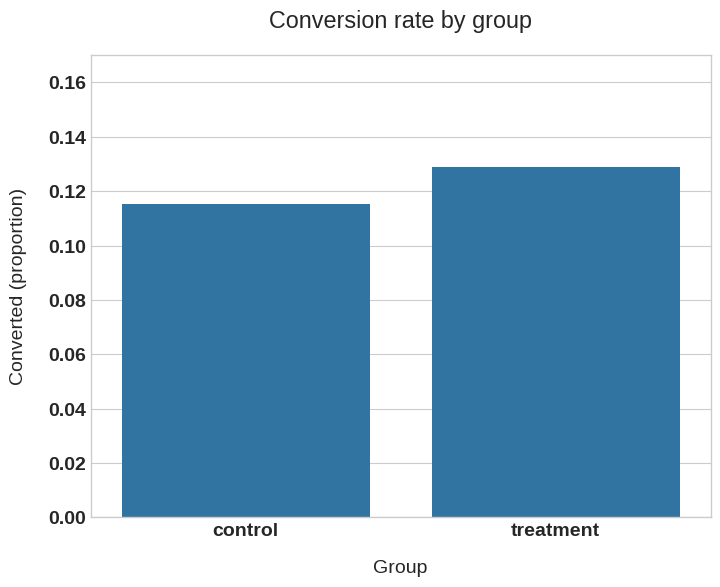

In [16]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=("ci", False) )

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

So… the treatment group's value is higher. Is this difference statistically significant?

# Testing the hypothesis

Since we have a very large sample, we can use the normal approximation for calculating our p-value (i.e. z-test).

There are other tests available: t-test, chi-squared

In [17]:
# Testing the hypothesis
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# getting count and proportion of conversion
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_control = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
n_observe = [n_control, n_treat]

# getting z statistic with z-test
z_stat, pval = proportions_ztest(successes, nobs=n_observe)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=n_observe, alpha=0.05)


print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.01
p-value: 0.044
ci 95% for control group: [0.106, 0.125]
ci 95% for treatment group: [0.119, 0.139]


# Drawing conclusions

p-value is 0.044, slightly less than 0.05, hence we can claim there is a difference between two design.

Looking at the confident interval, you notice that treatment group has a slightly higher interval.

we are 95\% certain that conversion rate for treatment group lies in 11.9\% and 13.9\%.

we are 95\% certain that conversion rate for control group lies in 10.6\% and 12.5\%.

However, it doesn't include the target rate we aimed for which is 15\%.

What this means is that it is more likely that the true conversion rate of the new design is close to similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!